In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras

import DataGenerator as DG
from DataGenerator import DataGenerator

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
#Progress bar fix: use callbacks=[Logger.JupyterProgbarLogger()] in model.fit
#verbose=0 is also required
import JupyterProgbarLogger as Logger
from tqdm import tqdm_notebook as tqdm
#from kerastuner.tuners import RandomSearch


import sklearn.metrics as metrics

import numpy as np
import random
import math

from datetime import datetime
import os.path
from shutil import copy

import matplotlib.pyplot as plt

import h5py

###FIX NUMPY LOAD FOR DICTIONARIES
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [2]:
#Data Variables
BATCH_SIZE=8
DATA_AMOUNT=2000000
VALIDATION_AMOUNT=20000
#frames per sample / 3rd dimension for 3D CNN
depth=8
filepath = "images_raw_doric_round1.h5"
scratch_dir = "/n/scratch2/ap487/"

In [3]:
if not os.path.exists((scratch_dir+filepath)):
    copy(filepath,scratch_dir)
    print("File Copied to scratch directory")
filepath=scratch_dir+filepath
print("Using path: ",filepath)

Using path:  /n/scratch2/ap487/images_raw_doric_round1.h5


In [4]:
def build_model(
                input_shape=(1,80, 80, 1),
                stride_length=(1, 1, 1),
                kernel=(3,3,3),
                kernel_initializer='glorot_uniform',
                activation=layers.Activation('relu'),
                dense_activation=layers.Activation('relu'),
                output_activation=layers.Activation('softmax'),
                batch_momentum=.999,
                dropout_chance=0.2,
                combine=True,
                padding='same',
                batch_norm=False,
                dropout=False
            ):
    name = "3D CNN"
    inputs = layers.Input(shape=input_shape)
    x = inputs
    conv_parameters = {
        'padding': padding,
        'strides': stride_length,
        'kernel_initializer': kernel_initializer,
    }
    # encode net
    #if batch_norm:
    #    x = layers.BatchNormalization(momentum=batch_momentum)(x)
    #elif dropout:
    #    x = layers.Dropout(dropout_chance)(x)
    #x = activation(x)
    x = layers.Conv3D(8, kernel, **conv_parameters)(x)
    x = layers.MaxPooling3D((1, 2, 2), padding=padding)(x)
    x = layers.Conv3D(16, kernel, **conv_parameters)(x)
    x = layers.Conv3D(16, kernel, **conv_parameters)(x)
    x = layers.MaxPooling3D((2, 2, 2), padding=padding)(x)
    x = layers.Conv3D(32, kernel, **conv_parameters)(x)
    x = layers.Conv3D(32, kernel, **conv_parameters)(x)
    x = layers.MaxPooling3D((2, 2, 2), padding=padding)(x)
    x = layers.Conv3D(64, kernel, **conv_parameters)(x)
    x = layers.Conv3D(64, kernel, **conv_parameters)(x)
    x = layers.MaxPooling3D((2, 2, 2), padding=padding)(x)
    x = activation(x)
    x = layers.GlobalAveragePooling3D()(x)
    output = output_activation(x)
    model = keras.models.Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=1e-3,
            momentum=0.9,
            nesterov=True,
            decay=1e-6
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model,name

In [5]:
if not depth == 1:
    model,name = build_model(input_shape=(depth,80,80,1))
else:
    model,name = build_model()
#print(model.summary())

W0725 09:13:55.484615 139968217618240 deprecation.py:506] From /home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
data_gen = DataGenerator(filepath,data_amount=DATA_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth)
validation_gen = DataGenerator(filepath,data_amount=VALIDATION_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=DATA_AMOUNT)
history = model.fit_generator(generator=data_gen,
                    validation_data=validation_gen,
                    epochs=25,
                    verbose=0,
                    use_multiprocessing=True,
                    workers=10,
                    callbacks=[Logger.JupyterProgbarLogger(count_mode='steps'),
                              keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10,verbose=1, mode='auto',restore_best_weights=True)]
                   )

Epoch 1/25


Metrics: loss: 2.1105 - acc: 0.2984 - val_loss: 1.6792 - val_acc: 0.4706

Epoch 2/25


Metrics: loss: 1.7622 - acc: 0.4722 - val_loss: 1.6092 - val_acc: 0.4763

Epoch 3/25


Metrics: loss: 1.7512 - acc: 0.4839 - val_loss: 1.7155 - val_acc: 0.4583

Epoch 4/25


Metrics: loss: 1.6518 - acc: 0.4941 - val_loss: 1.6579 - val_acc: 0.4788

Epoch 5/25


Metrics: loss: 1.6613 - acc: 0.5012 - val_loss: 1.5859 - val_acc: 0.4730

Epoch 6/25


Metrics: loss: 1.5945 - acc: 0.5104 - val_loss: 1.7554 - val_acc: 0.4690

Epoch 7/25


Metrics: loss: 1.6062 - acc: 0.5109 - val_loss: 1.5543 - val_acc: 0.5098

Epoch 8/25


Metrics: loss: 1.6391 - acc: 0.5063 - val_loss: 1.6952 - val_acc: 0.4796

Epoch 9/25


Metrics: loss: 1.6771 - acc: 0.5040 - val_loss: 1.7622 - val_acc: 0.4395

Epoch 10/25


Metrics: loss: 1.5939 - acc: 0.5169 - val_loss: 1.6967 - val_acc: 0.4534

Epoch 11/25


Metrics: loss: 1.6119 - acc: 0.5208 - val_loss: 1.5127 - val_acc: 0.5147

Epoch 12/25


Metrics: loss: 1.5860 - acc: 0.5201 - val_loss: 1.5732 - val_acc: 0.4861

Epoch 13/25


Metrics: loss: 1.5870 - acc: 0.5147 - val_loss: 1.5164 - val_acc: 0.5057

Epoch 14/25


Metrics: loss: 1.5906 - acc: 0.5212 - val_loss: 1.6522 - val_acc: 0.4804

Epoch 15/25


Metrics: loss: 1.6000 - acc: 0.5192 - val_loss: 1.4055 - val_acc: 0.5515

Epoch 16/25


Metrics: loss: 1.5243 - acc: 0.5275 - val_loss: 1.5523 - val_acc: 0.4967

Epoch 17/25


Process Keras_worker_ForkPoolWorker-311:
Process Keras_worker_ForkPoolWorker-319:
Process Keras_worker_ForkPoolWorker-323:
Process Keras_worker_ForkPoolWorker-321:
Process Keras_worker_ForkPoolWorker-325:
Process Keras_worker_ForkPoolWorker-317:
Process Keras_worker_ForkPoolWorker-326:
Process Keras_worker_ForkPoolWorker-314:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-315:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, *

  File "/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/utils/data_utils.py", line 571, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/site-packages/h5py/_hl/base.py", line 245, in id
    return self._id
  File "/home/ap487/2019-notebooks/Action Recognition/DataGenerator.py", line 36, in __getitem__
    return self.generate_chunk(index)
KeyboardInterrupt
  File "/home/ap487/2019-notebooks/Action Recognition/DataGenerator.py", line 61, in generate_chunk
    preload = f["/frames/raw"][index+self.skipped_frames:

KeyboardInterrupt: 

In [7]:
def accuracy(predictions, answers, top_n=5):
    accs = np.zeros(len(answers))
    predicts = np.zeros(len(test_labels))
    for i in range(0,len(answers)):
        j = len(predictions[i])-1
        for k in range(0,top_n):
            if predictions[i][j-k]==answers[i]:
                accs[i]=1
                predicts[i]=predictions[i][j-k]
    return np.mean(accs), predicts

In [9]:
with h5py.File(filepath,'r') as f:
    test_data=np.zeros((1000,depth,80,80))
    test_labels=np.zeros(1000)
    i=0
    #Starting index for batch samples
    index = 0
    while i < 1000:
        #Loop forward to add to the frame sequence
        cur_amount = 0
        while cur_amount < depth:
            label = f["/labels"][index]
            if label >= 0:
                test_data[i][cur_amount]=f["/frames/raw"][index]
                test_labels[i]=f["/labels"][index]
                index+=1
                cur_amount+=1
            else:
                index+=1
        i+=1
    test_data = test_data[...,None]

In [10]:
p = model.predict(test_data)
for i in range(0,len(p)):
    p[i]=np.argsort(p[i])

0.532


/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ap487/miniconda3/envs/tf2_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


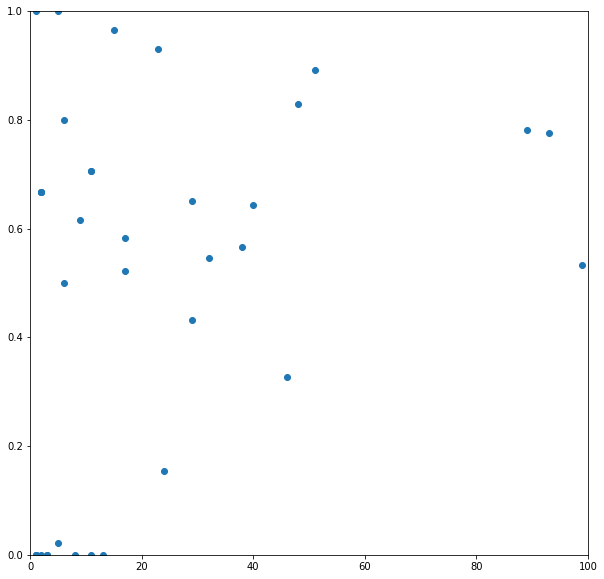

In [11]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
mean, predicts = accuracy(p,test_labels,top_n=1)
print(mean)
freqs = np.unique(test_labels,return_counts=True)[1]
f1 = metrics.f1_score(test_labels,predicts,average=None)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(freqs,f1)
plt.xlim(0,100)
plt.ylim(0,1)
np.set_printoptions(threshold=np.inf)
conf_mat=metrics.confusion_matrix(test_labels,[x[(len(x)-1)] for x in p])
conf_mat=conf_mat / conf_mat.astype(np.float).sum(axis=1,keepdims=True)
#print(np.array2string(conf_mat, max_line_width=np.inf))

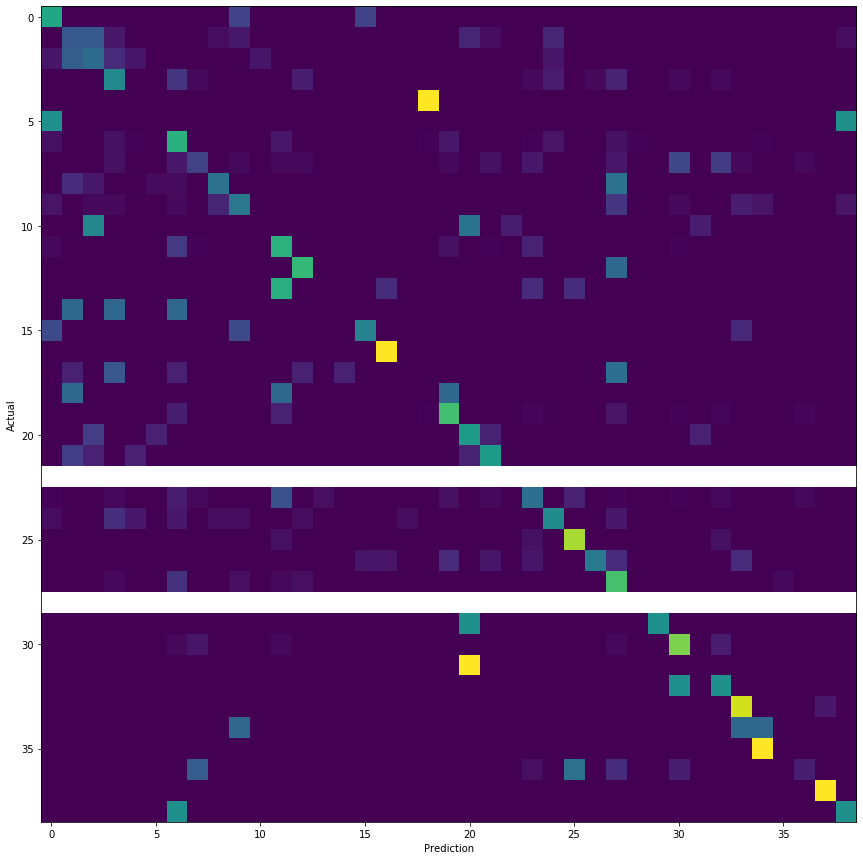

In [12]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(conf_mat)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [13]:
filename = "model-"+datetime.today().strftime('%Y-%m-%d-%H:%M:%S')+".h5"
model.save(filename)
print("Model saved to ",filename)

Model saved to  model-2019-07-25-12:57:07.h5


In [ ]:
model_benchmarks = np.load("benchmarks.npy")
model_benchmarks.item()[name]=metrics.f1_score(test_labels,predicts,average=None)
np.save("benchmarks.npy",model_benchmarks)
print(model_benchmarks)

In [ ]:
plt.plot(predicts)
plt.plot(test_labels)
#with h5py.File("images_raw_doric_round1.h5",'r') as f:
#    lbls = f["/labels"][:2000000:depth]
#plt.plot(lbls)
plt.xlim(800,830)
plt.show()

In [ ]:
#Old Data Function -- using DataGenerator now.
def sort_data(data,labels,train_len,val_len,test_len,blocksize=1):
    curBlock = labels[0]
    train_data = np.zeros((train_len,80,80,1))
    val_data = np.zeros((val_len,80,80,1))
    test_data = np.zeros((test_len,80,80,1))
    train_labels = np.full(train_len,-1)
    val_labels = np.full(val_len,-1)
    test_labels = np.full(test_len,-1)
    train_ind = 0
    val_ind = 0
    test_ind = 0
    choices = np.arange(3)
    i=0
    cur_len = 0
    while i < len(data):
        start = i-cur_len
        iter_amt = len(data) if blocksize == 1 else blocksize
        while labels[i]==curBlock and cur_len < iter_amt:
            i+=1
            cur_len+=1
            if i == len(data):
                break
        end = i
        if not i == len(data):
            if labels[i]==curBlock:
                cur_len-=int(blocksize/2)
            else:
                cur_len=0
            curBlock = labels[i]
        if not blocksize == 1 and end-start < blocksize:
            continue
        cur_frames = data[start:end]
        cur_labels = labels[start:end]
        choice=-1
        if choices.size>0:
            choice = np.random.choice(choices)
        else:
            break
        if choice == 0:
            if train_ind + len(cur_frames) >= train_len:
                cur_frames = cur_frames[:train_len-train_ind]
                cur_labels = cur_labels[:train_len-train_ind]
                choices=np.delete(choices,np.argwhere(choices==0))
            train_data[train_ind:train_ind+len(cur_frames)]=cur_frames
            train_labels[train_ind:train_ind+len(cur_frames)]=cur_labels
            train_ind += len(cur_frames)
        elif choice == 1:
            if val_ind + len(cur_frames) >= val_len:
                cur_frames = cur_frames[:val_len-val_ind]
                cur_labels = cur_labels[:val_len-val_ind]
                choices=np.delete(choices,np.argwhere(choices==1))
            val_data[val_ind:val_ind+len(cur_frames)]=cur_frames
            val_labels[val_ind:val_ind+len(cur_frames)]=cur_labels
            val_ind += len(cur_frames)
        elif choice == 2:
            if test_ind + len(cur_frames) >= test_len:
                cur_frames = cur_frames[:test_len-test_ind]
                cur_labels = cur_labels[:test_len-test_ind]
                choices=np.delete(choices,np.argwhere(choices==2))
            test_data[test_ind:test_ind+len(cur_frames)]=cur_frames
            test_labels[test_ind:test_ind+len(cur_frames)]=cur_labels
            test_ind += len(cur_frames)
    return train_data[:train_ind-(train_ind%blocksize)],train_labels[:train_ind-(train_ind%blocksize)],val_data[:val_ind-(val_ind%blocksize)],val_labels[:val_ind-(val_ind%blocksize)],test_data[:test_ind-(test_ind%blocksize)],test_labels[:test_ind-(test_ind%blocksize)]

In [ ]:
with h5py.File(filepath,'r') as f:
    print(f["/labels"][0:130])
data_gen.__getitem__(1)[1]

In [ ]:
pl = model.predict(data_gen.__getitem__(518)[0])
plc = np.zeros(len(pl))
for i in range (0,len(pl)):
    plc[i]=np.argmax(pl[i])
plt.plot(plc)
plt.plot(data_gen.__getitem__(518)[1])
plt.show()